In [ ]:
# Plot test role probes

In [ ]:
library(tidyverse)
library(fs)
library(ggtext)
library(systemfonts)

ws = '/workspace/deliberative-alignment-jailbreaks'
model_prefix = 'gptoss-20b'

source(paste0(ws, '/r-utils/plots.r'))

# Load data

In [ ]:
raw_df =
    read_csv(file.path(ws, str_glue('experiments/role-analysis/outputs/probe-projections/tomato-role-projections-{model_prefix}.csv')), trim_ws = FALSE) %>%
    # Add in bmt/seg id to allow for filtering later if needed
    group_by(role_space, layer_ix, prompt_key, prompt_ix, target_role) %>%
    arrange(., token_in_prompt_ix, .by_group = T) %>%
    mutate(seg_ix = consecutive_id(base_message_type)) %>%
    group_by(role_space, layer_ix, prompt_key, prompt_ix, target_role, seg_ix) %>%
    arrange(., sample_ix, .by_group = T) %>%
    mutate(token_in_seg_ix = row_number()) %>%
    ungroup() %>%
    filter(., role_space == 'suca') %>%
    filter(., layer_ix == 12) %>%
    select(., -role_space, -layer_ix)
    
head(raw_df, 1)

# Helpers

In [ ]:
# Helpers
options(repr.plot.width = 10, repr.plot.height = 6)

escape_md_html = function(x) {
  #' Escape markdown + HTML so they don't render in plots
  #' 
  #' @param x The string to escape
  #' @return character vector safe for ggtext::element_markdown()

  # Normalize platform newlines
  x = gsub("\r\n|\r", "\n", x, perl = TRUE)
  # Treat any literal <br> in the token text as a newline character; keeps own <br/> to add later separate
  x =  gsub("(?i)<br\\s*/?>", "\n", x, perl = TRUE)
  # Escape backslashes in the original text (so they render literally)
  x = gsub("\\\\", "\\\\\\\\", x, perl = TRUE)
  # Escape CommonMark punctuation so it renders literally
  x = gsub("([\\*_|`\\[\\]\\(\\)\\#\\~\\|!\\+\\-=])", "\\\\\\1", x, perl = TRUE)
  # Prevent HTML tag parsing by making < and > literal
  x = gsub("([<>])", "\\\\\\1", x, perl = TRUE)
  # Finally, convert real newline characters to the visible two chars "\n"
  #  (uses \\\\n in the replacement to emit a single backslash + n)
  x = gsub("\n", "\\\\n", x, perl = TRUE)

  return(x)
}

wrap_tokens = function(tokens, line_width, max_lines = 3) {
  #' Wrap tokens by # of characters
  #'
  #' @param tokens A vector of tokens to insert linebreaks into
  #' @param line_width The number of characters per line
  #' @param max_lines The maximum number of lines to retain

  lines = character(0)
  cur = ''
  used = 0L

  for (t in tokens) {
    cand = paste0(cur, t) # append next token as-is
    if (nchar(cand, type = "width") <= line_width || cur == "") {
      cur  <- cand
      used <- used + 1L
    } else {
      # push current line
      lines = c(lines, cur)
      if (length(lines) >= max_lines) {
        # stop collecting; we still count the remaining tokens as unused
        break
      }
      cur = t
      used = used + 1L
    }
  }
  if (length(lines) < max_lines && nzchar(cur)) {
    lines = c(lines, cur)
  }
  truncated = used < length(tokens) || length(lines) > max_lines
  res = list(lines = lines, truncated = truncated)
  return(res)
}

point_colors = c(
  'System' = '#90a1b9', # slate
  'User' = '#00a6f4', # sky
  'CoT' = '#fd9a00', # amber
  'Assistant' = '#00d492'  # emerald
)

text_colors = c(
  'System' = '#62748e', # slate
  'User' = '#0084d1', # sky
  'CoT' = '#e17100', # amber
  'Assistant' = '#009966'  # emerald
)


recode_and_relevel = function(x, recode_map, order) {
  #' Recode and relevel
  #' 
  #' @params recode_map 
  
  fct_relevel(fct_recode(x, !!!recode_map), !!!order)
}

# Test phase portraits

In [ ]:
# Plot full analysis results by segment, with systemness included
plot_df =
    raw_df %>%
    filter(., base_message_type != 'system') %>%
    group_by(prompt_key, prompt_ix, base_message_ix, target_role) %>%
    # mutate(prob_ewma = zoo::rollapply(prob, seq_along(prob), \(x) .25^(seq(length(x) - 1, 0)) %>% {sum(x * .)/sum(.)}, align = 'right', partial = T)) %>%
    ungroup() %>%    
    mutate(
        .,
        target_role = factor(
            target_role,
            levels = c('system', 'user', 'cot', 'assistant'),
            labels = c('Systemness', 'Userness', 'CoTness', 'Asstness')
        ),
        base_message_type = factor(
            base_message_type,
            levels = c('system', 'user', 'cot', 'assistant'),
            labels = c('System', 'User', 'CoT', 'Assistant')
        ),
        prompt_key = factor (
            prompt_key,
            levels = c('basic_no_format', 'everything_in_assistant_tags', 'everything_in_user_tags', 'proper_tags'),
            labels = c('No tags', 'Everything in assistant tags', 'Everything in user tags', 'Correct tags')
        )
    ) %>%
    filter(., token_in_seg_ix <= 160) %>%
    group_by(prompt_key, target_role) %>%
    arrange(., token_in_prompt_ix, .by_group = T) %>%
    mutate(., token_in_prompt_ix = 1:n()) %>%
    ungroup()

plots = map(group_split(plot_df, prompt_key), function(this_plot_df) {

    # Seg text + index for the start of each consecutive base_message_type segment
    segs =
        this_plot_df %>%
        # Collapse out target_role (lossless)
        distinct(prompt_ix, token_in_prompt_ix, seg_ix, base_message_type, token) %>%
        group_by(prompt_ix, seg_ix, base_message_type) %>%
        summarize(
            .,
            start_ix = first(token_in_prompt_ix),
            # Contiguous segment
            start_str = {
                nseg = n()
                bmt = first(base_message_type)
                seg_ix = first(seg_ix)
                line_width_chars = case_when(
                    bmt %in% c('User') ~ 4,
                    bmt %in% c('CoT') & seg_ix == 3 ~ 10,
                    bmt %in% c('CoT') ~ 14,
                    bmt %in% c('Assistant') ~ 24,
                    TRUE ~ 8
                )

                # Build up to 3 lines by character length
                wrapped = wrap_tokens(token, line_width = line_width_chars, max_lines = 2)

                # Escape Markdown/HTML inside the token content
                # Join with <br/>, append ellipsis if truncated
                escaped_lines =
                    map_chr(wrapped$lines, escape_md_html) %>%
                    paste0(., collapse = '<br>') %>%
                    {if(isTRUE(wrapped$truncated)) paste0(., '..') else .}

                escaped_lines
              },
            .groups = 'drop'
        ) %>%
        mutate(., start_str = str_glue('<span style="color:{text_colors[as.character(base_message_type)]}">{start_str}</span>')) 
        
    this_p =
        this_plot_df %>%
        ggplot() +
        geom_point(aes(x = token_in_prompt_ix, y = prob, color = base_message_type), size  = 0.3) +
        facet_grid(rows = vars(target_role), switch = 'y') +
        scale_y_continuous(
            labels = scales::percent_format(accuracy = 1),
            limits = c(0, 1),
            expand = expansion(mult = c(0.02, 0.02)),
            breaks = c(0, 1)
        ) +
        scale_x_continuous(
            breaks = segs$start_ix,
            labels = segs$start_str,
            expand = expansion(mult = c(0, 0))
        ) +
        scale_color_manual(values = point_colors, drop = FALSE) +
        labs(
            title = unique(this_plot_df$prompt_key),
            x = NULL,
            y = NULL,
            color = 'Token Style'
        ) +
        coord_cartesian(clip = "off") +
        theme_iclr(base_size = 9) +
        theme(
            # plot.title = ggtext::element_markdown(size = 10.5),
            legend.position = 'none',
            axis.title.y = ggtext::element_markdown(angle = 90, vjust = 0.5, margin = margin(r = 4)),
            strip.placement = 'outside',
            strip.text.y.left = element_text(size = 8, angle = 90, face = 'bold'),
            panel.spacing.y = unit(1.0, 'lines'),
            axis.text.x = ggtext::element_markdown(size = 8, hjust = 0, angle = 0)
        )

    ggsave(
        str_glue('{ws}/experiments/role-analysis/plots/tomato-role-space-projections2-{this_plot_df$prompt_key[[1]]}.pdf'),
        plot = this_p, width = 6.75, height = 3.4, units = 'in', dpi = 300, device = cairo_pdf
    )
    ggsave(
        str_glue('{ws}/experiments/role-analysis/plots/tomato-role-space-projections2-{this_plot_df$prompt_key[[1]]}.png'),
        plot = this_p,  width = 6.75, height = 3.4, units = 'in', dpi = 300
    )

    ggsave(
        str_glue('{ws}/docs/tomato-role-space-projections2-{this_plot_df$prompt_key[[1]]}.png'),
        plot = this_p, width = 6.75, height = 3.4, units = 'in', dpi = 300
    )
    print(this_p)
})

In [ ]:
# Line plot version
plot_df =
    raw_df %>%
    group_by(prompt_key, prompt_ix, seg_ix, target_role, base_message_ix) %>%
    mutate(prob_ewma = zoo::rollapply(prob, seq_along(prob), \(x) .9^(seq(length(x) - 1, 0)) %>% {sum(x * .)/sum(.)}, align = 'right', partial = T)) %>%
    ungroup() %>%    
    mutate(
        .,
        target_role = factor(
            target_role,
            levels = c('system', 'user', 'cot', 'assistant'),
            labels = c('Systemness', 'Userness', 'CoTness', 'Assistantness')
        ),
        base_message_type = factor(
            base_message_type,
            levels = c('system', 'user', 'cot', 'assistant'),
            labels = c('System', 'User', 'CoT', 'Assistant')
        ),
        prompt_key = factor (
            prompt_key,
            levels = c('basic_no_format', 'everything_in_assistant_tags', 'everything_in_user_tags', 'proper_tags'),
            labels = c('No tags', 'Everything in assistant tags', 'Everything in user tags', 'Correct tags')
        )
    ) %>%
    filter(., token_in_seg_ix <= 160) %>%
    group_by(prompt_key, target_role) %>%
    arrange(., token_in_prompt_ix, .by_group = T) %>%
    mutate(., token_in_prompt_ix = 1:n()) %>%
    ungroup()

plots = map(group_split(plot_df, prompt_key), function(this_plot_df) {

    # Seg text + index for the start of each consecutive base_message_type segment
    segs =
        this_plot_df %>%
        # Collapse out target_role (lossless)
        distinct(prompt_ix, token_in_prompt_ix, seg_ix, base_message_type, token) %>%
        group_by(prompt_ix, seg_ix, base_message_type) %>%
        summarize(
            .,
            start_ix = first(token_in_prompt_ix),
            # Contiguous segment
            start_str = {
                nseg = n()
                bmt = first(base_message_type)
                line_width_chars = case_when(
                    bmt %in% c('User') ~ 8,
                    bmt %in% c('CoT') ~ 14,
                    bmt %in% c('Assistant') ~ 34,
                    TRUE ~ 20
                )

                # Build up to 3 lines by character length
                wrapped = wrap_tokens(token, line_width = line_width_chars, max_lines = 2)

                # Escape Markdown/HTML inside the token content
                # Join with <br/>, append ellipsis if truncated
                escaped_lines =
                    map_chr(wrapped$lines, escape_md_html) %>%
                    paste0(., collapse = '<br>') %>%
                    {if(isTRUE(wrapped$truncated)) paste0(., '…') else .}

                escaped_lines
              },
            .groups = 'drop'
        ) %>%
        mutate(., start_str = str_glue('<span style="color:{text_colors[as.character(base_message_type)]}">{start_str}</span>')) 
        
    this_p =
        this_plot_df %>%
        ggplot() +
        geom_line(aes(x = token_in_prompt_ix, y = prob_ewma, color = base_message_type, group = seg_ix)) +
        facet_grid(rows = vars(target_role), switch = 'y') +
        scale_y_continuous(
            labels = scales::percent_format(accuracy = 1),
            limits = c(0, 1),
            expand = expansion(mult = c(0.02, 0.02)),
            breaks = c(0, 1)
        ) +
        scale_x_continuous(
            breaks = segs$start_ix,
            labels = segs$start_str,
            expand = expansion(mult = c(0, 0))
        ) +
        scale_color_manual(values = point_colors, drop = FALSE) +
        labs(
            title = unique(this_plot_df$prompt_key),
            x = NULL,
            y = NULL,
            color = 'Token Style'
        ) +
        coord_cartesian(clip = "off") +
        theme_iclr(base_size = 11) +
        theme(
            plot.title = ggtext::element_markdown(size = 11),
            legend.position = 'none',
            axis.title.y = ggtext::element_markdown(angle = 90, vjust = 0.5, margin = margin(r = 6)),
            strip.placement = 'outside',
            strip.text.y.left = element_text(angle = 90, face = 'bold'),
            panel.spacing.y = unit(1.0, "lines"),
            axis.text.x = ggtext::element_markdown(size = 9.5, hjust = 0, angle = 0)
        )

    print(this_p)
})

# Show CoTness only

In [ ]:
# Single prompt key (no role tags) + single role space
plot_df =
    raw_df %>%
    filter(base_message_type != 'system') %>%
    filter(target_role == 'cot') %>%
    filter(prompt_key == 'basic_no_format') %>%
    group_by(prompt_key, prompt_ix, seg_ix, target_role, base_message_ix) %>%
    mutate(prob_ewma = zoo::rollapply(prob, seq_along(prob), \(x) .25^(seq(length(x) - 1, 0)) %>% {sum(x * .)/sum(.)}, align = 'right', partial = T)) %>%
    ungroup() %>%    
    mutate(
        .,
        base_message_type = factor(
            base_message_type,
            levels = c('system', 'user', 'cot', 'assistant'),
            labels = c('System', 'User', 'CoT', 'Assistant')
        )
    ) %>%
    filter(., token_in_seg_ix <= 300) %>%
    arrange(., token_in_prompt_ix, .by_group = T) %>%
    mutate(., token_in_prompt_ix = 1:n()) %>%
    select(., -target_role, -prompt_key, -prompt_ix)

segs =
    plot_df %>%
    group_by(seg_ix, base_message_type) %>%
    summarize(
        .,
        start_ix = first(token_in_prompt_ix),
        # Contiguous segment
        start_str = {
            nseg = n()
            bmt = first(base_message_type)
            seg_ix = first(seg_ix)
            line_width_chars = case_when(
                bmt %in% c('User') ~ 6,
                bmt %in% c('CoT') & seg_ix == 3 ~ 10,
                bmt %in% c('CoT') ~ 12,
                bmt %in% c('Assistant') ~ 24,
                TRUE ~ 12
            )

            # Build up to 3 lines by character length
            wrapped = wrap_tokens(token, line_width = line_width_chars, max_lines = 2)

            # Escape Markdown/HTML inside the token content
            # Join with <br/>, append ellipsis if truncated
            escaped_lines =
                map_chr(wrapped$lines, escape_md_html) %>%
                paste0(., collapse = '<br>') %>%
                {if(isTRUE(wrapped$truncated)) paste0(., '..') else .}

            escaped_lines
            },
        .groups = 'drop'
    ) %>%
    mutate(., start_str = str_glue('<span style="color:{text_colors[as.character(base_message_type)]}">{start_str}</span>')) 
        
plot =
    plot_df %>%
    ggplot() +
    geom_point(aes(x = token_in_prompt_ix, y = prob_ewma, color = base_message_type), size = 0.4, alpha = 0.9) +
    # geom_line(aes(x = token_in_prompt_ix, y = prob_ewma, color = base_message_type, group = seg_ix), linewidth = 0.5, alpha = 0.7) +
    scale_y_continuous(
        labels = scales::percent_format(accuracy = 1),
        limits = c(0, 1),
        expand = expansion(mult = c(0.01, 0.01)),
        breaks = c(0, .25, .5, .75, 1)
    ) +
    scale_x_continuous(
        breaks = segs$start_ix,
        labels = segs$start_str,
        expand = expansion(mult = c(0, 0.01)),
    ) +
    scale_color_manual(values = point_colors, drop = FALSE) +
    labs(
        title = NULL,
        x = NULL,
        y = 'CoTness',
        color = 'Token Style'
    ) +
    coord_cartesian(clip = "off") +
    theme_iclr(base_size = 11) +
    theme(
        plot.title = ggtext::element_markdown(size = 10.5),
        legend.position = 'none',
        panel.grid.major.y = element_blank(),
        axis.title.y = ggtext::element_markdown(angle = 90, vjust = 0.5, margin = margin(r = 6)),
        axis.text.x = ggtext::element_markdown(size = 8.5, hjust = 0, angle = 0)
    )

# ggsave(
#     str_glue('{ws}/experiments/role-analysis/plots/tomato-role-space-cotness-only.pdf'),
#     plot = plot, width = 7, height = 3.0, units = 'in', dpi = 300, device = cairo_pdf
# )
# ggsave(
#     str_glue('{ws}/experiments/role-analysis/plots/tomato-role-space-cotness-only.png'),
#     plot = plot,  width = 7, height = 3.0, units = 'in', dpi = 300
# )

# ggsave(
#     str_glue('{ws}/docs/tomato-role-space-cotness-only.png'),
#     plot = plot, width = 7, height = 3.0, units = 'in', dpi = 300
# )

print(plot)

In [ ]:
# Single prompt key (no role tags) + single role space
plot_df =
    raw_df %>%
    filter(base_message_type != 'system') %>%
    filter(target_role == 'cot') %>%
    filter(prompt_key == 'basic_no_format') %>%
    group_by(prompt_key, prompt_ix, seg_ix, target_role, base_message_ix) %>%
    mutate(prob_ewma = zoo::rollapply(prob, seq_along(prob), \(x) .5^(seq(length(x) - 1, 0)) %>% {sum(x * .)/sum(.)}, align = 'right', partial = T)) %>%
    ungroup() %>%    
    mutate(
        .,
        base_message_type = factor(
            base_message_type,
            levels = c('system', 'user', 'cot', 'assistant'),
            labels = c('System', 'User', 'CoT', 'Assistant')
        )
    ) %>%
    filter(., token_in_seg_ix <= 300) %>%
    arrange(., token_in_prompt_ix, .by_group = T) %>%
    mutate(., token_in_prompt_ix = 1:n()) %>%
    select(., -target_role, -prompt_key, -prompt_ix)

segs =
    plot_df %>%
    group_by(seg_ix, base_message_type) %>%
    summarize(
        .,
        start_ix = first(token_in_prompt_ix),
        # Contiguous segment
        start_str = {
            nseg = n()
            bmt = first(base_message_type)
            seg_ix = first(seg_ix)
            line_width_chars = case_when(
                bmt %in% c('User') ~ 6,
                bmt %in% c('CoT') & seg_ix == 3 ~ 10,
                bmt %in% c('CoT') ~ 12,
                bmt %in% c('Assistant') ~ 24,
                TRUE ~ 12
            )

            # Build up to 3 lines by character length
            wrapped = wrap_tokens(token, line_width = line_width_chars, max_lines = 2)

            # Escape Markdown/HTML inside the token content
            # Join with <br/>, append ellipsis if truncated
            escaped_lines =
                map_chr(wrapped$lines, escape_md_html) %>%
                paste0(., collapse = '<br>') %>%
                {if(isTRUE(wrapped$truncated)) paste0(., '..') else .}

            escaped_lines
            },
        .groups = 'drop'
    ) %>%
    mutate(., start_str = str_glue('<span style="color:{text_colors[as.character(base_message_type)]}">{start_str}</span>')) 
        
plot =
    plot_df %>%
    ggplot() +
    geom_point(aes(x = token_in_prompt_ix, y = prob_ewma, color = base_message_type), size = 0.5, alpha = 0.9) +
    geom_line(aes(x = token_in_prompt_ix, y = prob_ewma, color = base_message_type, group = seg_ix), linewidth = 0.5, alpha = 0.7) +
    scale_y_continuous(
        labels = scales::percent_format(accuracy = 1),
        limits = c(0, 1),
        expand = expansion(mult = c(0.01, 0.01)),
        breaks = c(0, .25, .5, .75, 1)
    ) +
    scale_x_continuous(
        breaks = segs$start_ix,
        labels = segs$start_str,
        expand = expansion(mult = c(0, 0.01)),
    ) +
    scale_color_manual(values = point_colors, drop = FALSE) +
    labs(
        title = NULL,
        x = NULL,
        y = 'CoTness',
        color = 'Token Style'
    ) +
    coord_cartesian(clip = "off") +
    theme_iclr(base_size = 11) +
    theme(
        plot.title = ggtext::element_markdown(size = 10.5),
        legend.position = 'none',
        panel.grid.major.y = element_blank(),
        axis.title.y = ggtext::element_markdown(angle = 90, vjust = 0.5, margin = margin(r = 6)),
        axis.text.x = ggtext::element_markdown(size = 8.5, hjust = 0, angle = 0)
    )

# ggsave(
#     str_glue('{ws}/experiments/role-analysis/plots/tomato-role-space-cotness-only.pdf'),
#     plot = plot, width = 7, height = 3.0, units = 'in', dpi = 300, device = cairo_pdf
# )
# ggsave(
#     str_glue('{ws}/experiments/role-analysis/plots/tomato-role-space-cotness-only.png'),
#     plot = plot,  width = 7, height = 3.0, units = 'in', dpi = 300
# )

# ggsave(
#     str_glue('{ws}/docs/tomato-role-space-cotness-only.png'),
#     plot = plot, width = 7, height = 3.0, units = 'in', dpi = 300
# )

print(plot)

# Compare alternative tags (phase portrait)

In [ ]:
# Without systemness
# CoTness only
# With all assistant, all user
plot_df =
    raw_df %>%
    filter(base_message_type != 'system') %>%
    filter(target_role != 'system') %>%
    filter(., prompt_key %in% c('basic_no_format', 'proper_tags')) %>%
    group_by(prompt_key, prompt_ix, seg_ix, target_role, base_message_ix) %>%
    mutate(prob_ewma = zoo::rollapply(prob, seq_along(prob), \(x) .5^(seq(length(x) - 1, 0)) %>% {sum(x * .)/sum(.)}, align = 'right', partial = T)) %>%
    ungroup() %>%    
    mutate(
        ., 
        target_role = factor(
            target_role,
            levels = c('user', 'cot', 'assistant'),
            labels = c('Userness', 'CoTness', 'Assistantness')
        ),
        base_message_type = factor(
            base_message_type,
            levels = c('user', 'cot', 'assistant'),
            labels = c('User', 'CoT', 'Assistant')
        ),
        prompt_key = factor (
            prompt_key,
            levels = c('proper_tags', 'basic_no_format'),
            labels = c('Correct Tags', 'No tags')
        )
    ) %>%
    filter(., token_in_seg_ix <= 120) %>%
    filter(., target_role == 'CoTness') %>%
    select(., -target_role)


# Get only (seg_id, token_in_seg_ix) pairs s.t. all 4 prompt keys have the same value
# This handles minor issues with boundary role assignment (usually the last token of each seg)
seg_ix_token_in_seg_ix_pairs_to_retain =
    plot_df %>%
    group_by(seg_ix, token_in_seg_ix) %>%
    summarize(
        ., 
        n_distinct_toks = n_distinct(token),
        n_distinct_prompts = n_distinct(prompt_key),
        .groups = 'drop'
    ) %>%
    filter(., n_distinct_prompts == length(unique(plot_df$prompt_key)) & n_distinct_toks == 1)

plot_df_filtered =
    plot_df %>%
    inner_join(., seg_ix_token_in_seg_ix_pairs_to_retain, by = c('seg_ix', 'token_in_seg_ix')) %>%
    group_by(prompt_key) %>%
    arrange(., seg_ix, token_in_seg_ix, .by_group = T) %>%
    mutate(., token_in_prompt_ix = 1:n()) %>%
    ungroup(.)

# Seg text + index for the start of each consecutive base_message_type segment
segs =
    plot_df_filtered %>%
    group_by(prompt_ix, seg_ix, base_message_type) %>%
    summarize(
        .,
        start_ix = first(token_in_prompt_ix),
        # Contiguous segment
        start_str = {
            nseg = n()
            seg_ix = first(seg_ix)
            bmt = first(base_message_type)
            line_width_chars = case_when(
                bmt %in% c('User') ~ 6,
                bmt %in% c('CoT') & seg_ix == 3 ~ 8,
                bmt %in% c('CoT') ~ 18,
                bmt %in% c('Assistant') ~ 22,
                TRUE ~ 16
            )

            # Build up to 3 lines by character length
            wrapped = wrap_tokens(token, line_width = line_width_chars, max_lines = 2)

            # Escape Markdown/HTML inside the token content
            # Join with <br/>, append ellipsis if truncated
            escaped_lines =
                map_chr(wrapped$lines, escape_md_html) %>%
                paste0(., collapse = '<br>') %>%
                {if(isTRUE(wrapped$truncated)) paste0(., '…') else .}

            if (length(escaped_lines) > 1) print(escaped_lines)

            escaped_lines
            },
        .groups = 'drop'
    ) %>%
    mutate(., start_str = str_glue('<span style="color:{text_colors[2:4][as.character(base_message_type)]}">{start_str}</span>')) %>%
    mutate(., start_str = ifelse(prompt_ix == 0, start_str, ''))
    
plot =
    plot_df_filtered %>%
    ggplot() +
    geom_point(aes(x = token_in_prompt_ix, y = prob_ewma, color = base_message_type), size = 0.5, alpha = 0.9) +
    geom_line(aes(x = token_in_prompt_ix, y = prob_ewma, color = base_message_type, group = seg_ix), linewidth = 0.5, alpha = 0.7) +
    facet_grid(rows = vars(prompt_key), switch = 'y') +
    scale_y_continuous(
        labels = scales::percent_format(accuracy = 1),
        limits = c(0, 1),
        expand = expansion(mult = c(0.02, 0.02)),
        breaks = c(0, 1)
    ) +
    scale_x_continuous(
        breaks = segs$start_ix,
        labels = segs$start_str,
        expand = expansion(mult = c(0, 0))
    ) +
    scale_color_manual(values = point_colors[2:4], drop = FALSE) +
    labs(
        x = NULL,
        y = 'CoTness',
        color = 'Token Style'
    ) +
    coord_cartesian(clip = 'off') +
    theme_iclr(base_size = 11) +
    theme(
        legend.position = 'none',
        axis.title.y = ggtext::element_markdown(angle = 90, vjust = 0.5, margin = margin(r = 6)),
        strip.placement = 'outside',
        strip.text.y.left = element_text(angle = 90, face = 'bold', size = 10),
        panel.spacing.y = unit(1.0, 'lines'),
        axis.text.x = ggtext::element_markdown(size = 9, hjust = 0, angle = 0)
    )

# ggsave(
#     str_glue('{ws}/experiments/role-analysis/plots/cotness-phase-portrait-alt-tags.pdf'),
#     plot = plot, width = 7, height = 3.8, units = 'in', dpi = 300, device = cairo_pdf
# )
# ggsave(
#     str_glue('{ws}/experiments/role-analysis/plots/cotness-phase-portrait-alt-tags.png'),
#     plot = plot,  width = 7, height = 3.8, units = 'in', dpi = 300
# )

# ggsave(
#     str_glue('{ws}/docs/cotness-phase-portrait-alt-tags.png'),
#     plot = plot, width = 7, height = 3.8, units = 'in', dpi = 300
# )

plot

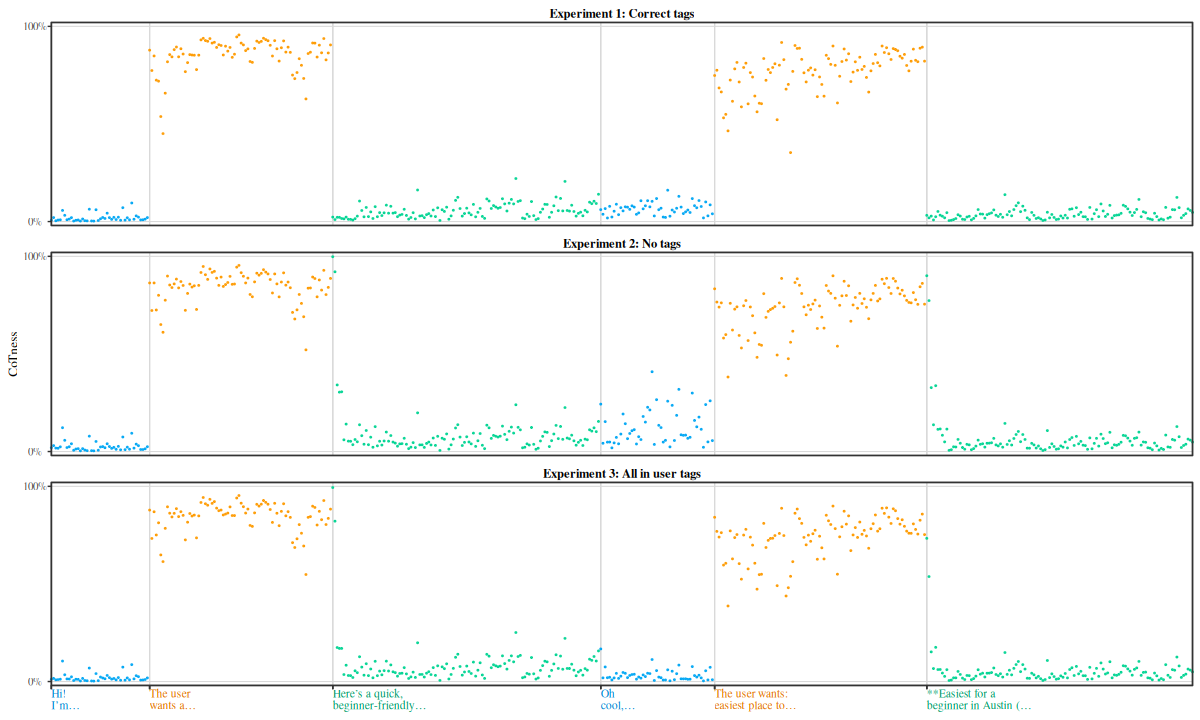

In [ ]:
plot_df =
    raw_df %>%
    filter(base_message_type != 'system') %>%
    filter(target_role != 'system') %>%
    filter(., prompt_key %in% c('basic_no_format', 'everything_in_user_tags', 'proper_tags')) %>%
    group_by(prompt_key, prompt_ix, seg_ix, target_role, base_message_ix) %>%
    arrange(., seg_ix, token_in_seg_ix, .by_group = T) %>%
    mutate(prob_ewma = zoo::rollapply(prob, seq_along(prob), \(x) .5^(seq(length(x) - 1, 0)) %>% {sum(x * .)/sum(.)}, align = 'right', partial = T)) %>%
    ungroup() %>%    
    mutate(
        ., 
        target_role = factor(
            target_role,
            levels = c('user', 'cot', 'assistant'),
            labels = c('Userness', 'CoTness', 'Assistantness')
        ),
        base_message_type = factor(
            base_message_type,
            levels = c('user', 'cot', 'assistant'),
            labels = c('User', 'CoT', 'Assistant')
        ),
        prompt_key = factor (
            prompt_key,
            levels = c('proper_tags', 'basic_no_format', 'everything_in_user_tags'),
            labels = c('Experiment 1: Correct tags', 'Experiment 2: No tags', 'Experiment 3: All in user tags')
        )
    ) %>%
    filter(., token_in_seg_ix <= 120) %>%
    filter(., target_role == 'CoTness') %>%
    select(., -target_role)


# Get only (seg_id, token_in_seg_ix) pairs s.t. all 4 prompt keys have the same value
# This handles minor issues with boundary role assignment (usually the last token of each seg)
seg_ix_token_in_seg_ix_pairs_to_retain =
    plot_df %>%
    group_by(seg_ix, token_in_seg_ix) %>%
    summarize(
        ., 
        n_distinct_toks = n_distinct(token),
        n_distinct_prompts = n_distinct(prompt_key),
        .groups = 'drop'
    ) %>%
    filter(., n_distinct_prompts == length(unique(plot_df$prompt_key)) & n_distinct_toks == 1)

plot_df_filtered =
    plot_df %>%
    inner_join(., seg_ix_token_in_seg_ix_pairs_to_retain, by = c('seg_ix', 'token_in_seg_ix')) %>%
    group_by(prompt_key) %>%
    arrange(., seg_ix, token_in_seg_ix, .by_group = T) %>%
    mutate(., token_in_prompt_ix = 1:n()) %>%
    ungroup(.)

# Seg text + index for the start of each consecutive base_message_type segment
segs =
    plot_df_filtered %>%
    group_by(prompt_ix, seg_ix, base_message_type) %>%
    summarize(
        .,
        start_ix = first(token_in_prompt_ix),
        # Contiguous segment
        start_str = {
            nseg = n()
            seg_ix = first(seg_ix)
            bmt = first(base_message_type)
            line_width_chars = case_when(
                bmt %in% c('User') ~ 6,
                bmt %in% c('CoT') & seg_ix == 3 ~ 8,
                bmt %in% c('CoT') ~ 18,
                bmt %in% c('Assistant') ~ 22,
                TRUE ~ 16
            )

            # Build up to 3 lines by character length
            wrapped = wrap_tokens(token, line_width = line_width_chars, max_lines = 2)

            # Escape Markdown/HTML inside the token content
            # Join with <br/>, append ellipsis if truncated
            escaped_lines =
                map_chr(wrapped$lines, escape_md_html) %>%
                paste0(., collapse = '<br>') %>%
                {if(isTRUE(wrapped$truncated)) paste0(., '…') else .}

            if (length(escaped_lines) > 1) print(escaped_lines)

            escaped_lines
            },
        .groups = 'drop'
    ) %>%
    mutate(., start_str = str_glue('<span style="color:{text_colors[2:4][as.character(base_message_type)]}">{start_str}</span>')) %>%
    mutate(., start_str = ifelse(prompt_ix == 0, start_str, ''))
    
plot =
    plot_df_filtered %>%
    ggplot() +
    geom_point(aes(x = token_in_prompt_ix, y = prob, color = base_message_type), size = 0.3, alpha = 0.9) +
    # geom_line(aes(x = token_in_prompt_ix, y = prob_ewma, color = base_message_type, group = seg_ix), linewidth = 0.2, alpha = 0.5) +
    # facet_grid(rows = vars(prompt_key), switch = 'y') +
    facet_wrap(~prompt_key, ncol = 1, strip.position = "top") +  # CHANGED: use facet_wrap
    scale_y_continuous(
        labels = scales::percent_format(accuracy = 1),
        limits = c(0, 1),
        expand = expansion(mult = c(0.02, 0.02)),
        breaks = c(0, 1)
    ) +
    scale_x_continuous(
        breaks = segs$start_ix,
        labels = segs$start_str,
        expand = expansion(mult = c(0, 0))
    ) +
    scale_color_manual(values = point_colors[2:4], drop = FALSE) +
    labs(
        x = NULL,
        y = 'CoTness',
        color = 'Token Style'
    ) +
    coord_cartesian(clip = 'off') +
    theme_iclr(base_size = 9) +
    theme(
        legend.position = 'none',
        axis.title.y = ggtext::element_markdown(size = 8, angle = 90, vjust = 0.5, margin = margin(r = 1)),
        strip.text = element_text(face = 'bold', size = 7.5, margin = margin(b = 2)),
        panel.spacing.y = unit(0.5, 'lines'),
        axis.text.x = ggtext::element_markdown(size = 7, hjust = 0, angle = 0)
    )

ggsave(
    str_glue('{ws}/experiments/role-analysis/plots/cotness-phase-portrait-alt-tags-4-2.pdf'),
    plot = plot, width = 6.75, height = 2.8, units = 'in', dpi = 300, device = cairo_pdf
)
ggsave(
    str_glue('{ws}/experiments/role-analysis/plots/cotness-phase-portrait-alt-tags-4-2.png'),
    plot = plot,  width = 6.75, height = 2.8, units = 'in', dpi = 300
)

ggsave(
    str_glue('{ws}/docs/cotness-phase-portrait-alt-tags-4-2.png'),
    plot = plot, width = 6.75, height = 2.8, units = 'in', dpi = 300
)

plot